<a href="https://colab.research.google.com/github/RuiyunHuang/Car_Model_Detection/blob/master/Car_model_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Introduction

This project is to build a image classifier for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. Car classes are in form of Year, Make, Model, e.g. 2012 BMW M3 coupe.The data includes 8,144 training images and 8,041 testing images.

It is generally bad to directly train deep learning model on this dataset since the number of images is small. Thus **transfer learning**, a common approch used in deep learning to utilize the pretrained model on [imagenet](http://www.image-net.org/), is used and then tunned on this car dataset.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

# 1. Import Data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp ./drive/My\ Drive/Colab\ Notebooks/stanford_car_dataset.zip ./
!mkdir ./stanford_car_dataset
!unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset

# 2. Load Packages and Start GPU

In [0]:
# import common and pytorch packages
import time, os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
from IPython.display import display
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [4]:
# enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(device))

cuda
Tesla P100-PCIE-16GB


# 3.Train Model

In [0]:
# calculate new mean and std for normalization when necessary
def calculate_mean_std(file_path, figure_size, batch_size):
    temp_trans = transforms.Compose([
        transforms.Resize(figure_size),
        transforms.ToTensor()
    ])
    temp_dataset = torchvision.datasets.ImageFolder(root = file_path+"train", transform=temp_trans)
    temp_dataloader = torch.utils.data.DataLoader(temp_dataset, batch_size=batch_size, num_workers=4)

    for i, data in enumerate(temp_dataloader, 0):   
        temp, label=data
        mean=torch.mean(temp, axis=(0,2,3))
        std=torch.std(temp, axis=(0,2,3))
    return mean, std

In [0]:
# image transformation/augmentation
file_path = "stanford_car_dataset/car_data/car_data/"
width = height = 224
figure_size=(width, height)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 32

train_trans = transforms.Compose([
    transforms.Resize(figure_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_trans = transforms.Compose([
    transforms.Resize(figure_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# create dataloaders for mini-batch
train_dataset = torchvision.datasets.ImageFolder(file_path+"train", transform=train_trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.ImageFolder(file_path+"test", transform=test_trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [0]:
# define model trainer for trainning and evaluation
class ModelTrainer():
    def __init__(self, model, criterion, optimizer, scheduler, n_epochs=5):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.n_epochs = n_epochs
        self.classes = None

        self.time = torch.zeros(n_epochs)
        self.losses = torch.zeros(n_epochs)
        self.train_accuracy = torch.zeros(n_epochs)
        self.test_accuracy = torch.zeros(n_epochs)
        self.train_metrics = None
        self.test_metrics = None

        self.prediction_trans = None

    # fitting function for model trainning
    def fit(self, train_dataloader, test_dataloader=None):
        # initialize confusion matrix
        self.classes = train_dataloader.dataset.classes
        tmp = len(self.classes)
        self.train_metrics = torch.zeros(self.n_epochs, tmp, tmp)
        self.test_metrics = torch.zeros(self.n_epochs, tmp, tmp)
        # get transformer for prediction
        if test_dataloader:
            self.prediction_trans = test_dataloader.dataset.transform
        else:
            tmp = np.array(train_dataloader.dataset.transform.transforms)[[0, -2, -1]].tolist()
            self.prediction_trans = transforms.Compose(tmp)
        # training
        for epoch in tqdm_notebook(range(self.n_epochs)):
            starting_time = time.time()
            running_losses = 0.0
            self.model.train()
            for i, data in enumerate(train_dataloader, 0):
                # load inputs to GPU
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                # forward/backward propagation
                with torch.set_grad_enabled(True):
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()
                # accumulate the running loss/confusion matrix for each minibatch
                running_losses += loss.item() * labels.size(0)
                self._metrics(preds, labels, self.train_metrics[epoch])
            # store the loss/accuracy/train time for each epoch
            self.losses[epoch] = running_losses / len(train_dataloader.dataset)
            self.train_accuracy[epoch] = self._accuracy(self.train_metrics[epoch])
            if test_dataloader:
                test_acc = self._evaluate(test_dataloader, epoch)
            self.time[epoch] = time.time() - starting_time
            print("epoch %s, duration: %d s, loss: %.4f, acc_train: %.4f, acc_test: %.4f" % (epoch+1, self.time[epoch], self.losses[epoch], self.train_accuracy[epoch], self.test_accuracy[epoch]))
            self.scheduler.step(test_acc)

    # predict a new image
    def predict(self, img):
        if self.prediction_trans:
            tmp = self.prediction_trans(img).unsqueeze(0).cuda()
            self.model.eval()
            with torch.no_grad():
                output = self.model(tmp)
                softmax = torch.nn.Softmax()
                _pro, _id = torch.max(softmax(output), 1)
            return _pro, self.classes[_id]
        else:
          return None
        id
    
    # evaluate model with test data
    def _evaluate(self, test_dataloader, epoch):
        self.model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs , 1)
                self._metrics(preds, labels, self.test_metrics[epoch])
        acc = self._accuracy(self.test_metrics[epoch])     
        self.test_accuracy[epoch] = acc
        return acc

    # update confusion metrics
    def _metrics(self, preds, labels, cur):
        for _ in range(len(preds)):
            cur[preds[_]][labels[_]] +=1

    # calculate accuracy
    def _accuracy(self, metrics):
        return metrics.diag().sum() / metrics.sum()

In [8]:
# build transfer learning model from resnet32
car_classes = 196
model = models.resnet34(pretrained=True)
num_fc = model.fc.in_features
model.fc = nn.Linear(num_fc, car_classes)
model = model.to(device)

# choose loss function/optimization method/learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

n_epochs=12
modeltrainer=ModelTrainer(model, criterion, optimizer, lrscheduler, n_epochs)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [9]:
# fit model
modeltrainer.fit(train_dataloader, test_dataloader)

epoch 1, duration: 155 s, loss: 3.9455, acc_train: 0.1489, acc_test: 0.3022
epoch 2, duration: 157 s, loss: 1.9537, acc_train: 0.4769, acc_test: 0.4608
epoch 3, duration: 159 s, loss: 1.2488, acc_train: 0.6424, acc_test: 0.5644
epoch 4, duration: 157 s, loss: 0.8746, acc_train: 0.7398, acc_test: 0.6680
epoch 5, duration: 156 s, loss: 0.6208, acc_train: 0.8134, acc_test: 0.6472
epoch 6, duration: 155 s, loss: 0.4592, acc_train: 0.8571, acc_test: 0.6917
epoch 7, duration: 155 s, loss: 0.3367, acc_train: 0.9000, acc_test: 0.6840
epoch 8, duration: 156 s, loss: 0.3080, acc_train: 0.9046, acc_test: 0.7321
epoch 9, duration: 155 s, loss: 0.1321, acc_train: 0.9649, acc_test: 0.8306
epoch 10, duration: 155 s, loss: 0.0772, acc_train: 0.9810, acc_test: 0.8433
epoch 11, duration: 154 s, loss: 0.0623, acc_train: 0.9854, acc_test: 0.8447
epoch 12, duration: 155 s, loss: 0.0545, acc_train: 0.9888, acc_test: 0.8463



# 4.Visualize Results

In [0]:
# calculate the precision and recall
def recall_precision(metrics):
    cm = metrics
    recall = np.diag(cm) / np.sum(cm, axis = 0)
    precision = np.diag(cm) / np.sum(cm, axis = 1)
    F1 = np.mean(recall) * np.mean(precision) * 2 / (np.mean(precision) + np.mean(recall))
    print("Recall: {}, Precision: {}, F1: {}".format(np.mean(recall), np.mean(precision), F1))

In [11]:
modeltrainer.train_metrics[7].numpy()

array([[41.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 43.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 23., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 40.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 41.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 40.]], dtype=float32)

In [12]:
recall_precision(modeltrainer.train_metrics[7].numpy())

Recall: 0.9039320945739746, Precision: 0.904941976070404, F1: 0.904436726238993


In [13]:
recall_precision(modeltrainer.test_metrics[7].numpy())

Recall: 0.7309017777442932, Precision: 0.7749142050743103, F1: 0.7522647782958747


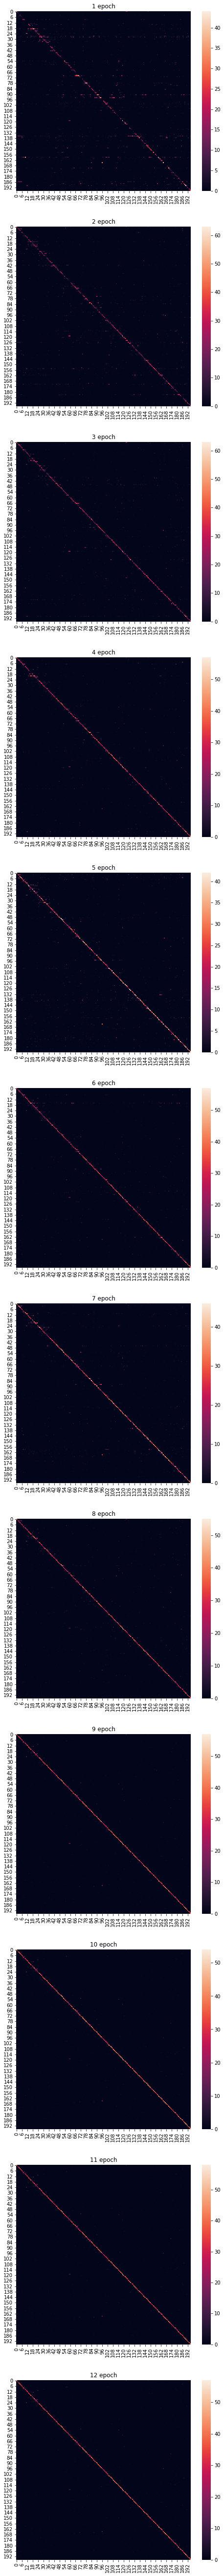

In [14]:
import seaborn as sns

# plot confusion matrix vs. epoch
plt.figure(figsize=[8,8*n_epochs])
for i in range(n_epochs):
    plt.subplot(n_epochs, 1, i+1)
    plt.title(str(i+1) + ' epoch')
    sns.heatmap(modeltrainer.test_metrics[i].numpy())

In [15]:
# install ngrok(it is necessary for colab to use tensorboard)
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-02-27 03:06:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.200.179.34, 34.193.139.214, 34.238.36.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.200.179.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.6MB/s    in 0.7s    

2020-02-27 03:06:11 (18.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [16]:
# create a link to view tensorboard results
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &amp;')

print("The link to tensorboard:")
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

The link to tensorboard:
https://8737b828.ngrok.io


In [0]:
# plot predictions of some random test images
def plot_test(modeltrainer=modeltrainer, test_dataset=test_dataset, size=9):
    samples = np.random.randint(0, len(test_dataset.samples), size=size)
    fig = plt.figure(figsize=[8, size*8])
    for i, id in enumerate(samples):
        ax = fig.add_subplot(size, 1, i+1, xticks=[], yticks=[])
        url = test_dataset.samples[id][0]
        img = Image.open(url)
        plt.imshow(img)
        modeltrainer.model.to(device)
        confidence, model = modeltrainer.predict(img)
        label = modeltrainer.classes[test_dataset.samples[id][1]]
        ax.set_title("prediction: {}, confidence: {}.4f %, label: {}".format(model, confidence.item()*100, label), color=("green" if model==label else "red"))
    return fig

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# send loss/accuracy plot to tensorboard
for i in range(n_epochs):
    writer.add_scalar("Training Loss", modeltrainer.losses[i], i+1)
    writer.add_scalar("Accuracy/Training", modeltrainer.train_accuracy[i], i+1)
    writer.add_scalar("Accuracy/Testing", modeltrainer.test_accuracy[i], i+1)

# send transformed test images to tensorboard
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
grid = torchvision.utils.make_grid(images.cpu())
writer.add_image("Image_transformed", grid, 0)

# send predictions of some random test images to tensorboard
image2 = plot_test()
writer.add_figure("Prediction", image2)

# send the model to tensorboard
writer.add_graph(modeltrainer.model.to("cpu"), images)
writer.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# 5. Application

confidence: 89.18970227241516.4f %, model: Audi A5 Coupe 2012


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


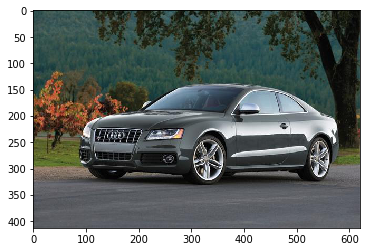

In [19]:
import requests
from io import BytesIO

# test on random image from web
def web_predict(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    modeltrainer.model.to(device)
    confidence, model = modeltrainer.predict(img)

    plt.imshow(img)
    print("confidence: {}.4f %, model: {}".format(confidence.item()*100, model))

web_predict("https://images.autotrader.com/scaler/620/420/cms/content/articles/reviews/new/audi/s5/2012/168858.jpg")